In [1]:
from pathlib import Path
import sys

# Get the qaoa-repro root directory (parent of notebooks/)
repo_root = Path.cwd().resolve().parent
# Add the repo root to path so 'src' package is importable
sys.path.insert(0, str(repo_root))

In [3]:
# Cell 1: imports
import numpy as np
import networkx as nx
from src.qaoa_sim import build_qaoa_circuit, statevector_from_circuit, expected_cost_from_statevector, sample_bitstrings, energy_from_counts, best_sampled_solution
from src.instances import generate_regular_graph, generate_random_knapsack
from src.knapsack_mapping import knapsack_to_ising
from src.metrics import ground_state_energy_by_enumeration, success_probability_from_counts, approximation_ratio
from src.viz import plot_heatmap, plot_histogram
import matplotlib.pyplot as plt


In [4]:
# Cell 2: generate MaxCut graph
G = generate_regular_graph(n=6, deg=3, seed=42)
n = G.number_of_nodes()
# Build h and J for unweighted MaxCut: H_C = sum_{(i,j)} J_ij Z_i Z_j with J_ij = 0.5 (or 1 depending on normalization)
h = {i: 0.0 for i in range(n)}
J = {}
for (i,j) in G.edges():
    # using J = 0.5 or 1; choose J=1 for simplicity
    a, b = min(i,j), max(i,j)
    J[(a,b)] = 1.0


FileNotFoundError: [Errno 2] No such file or directory: 'results/figures/maxcut_p1_heatmap.png'

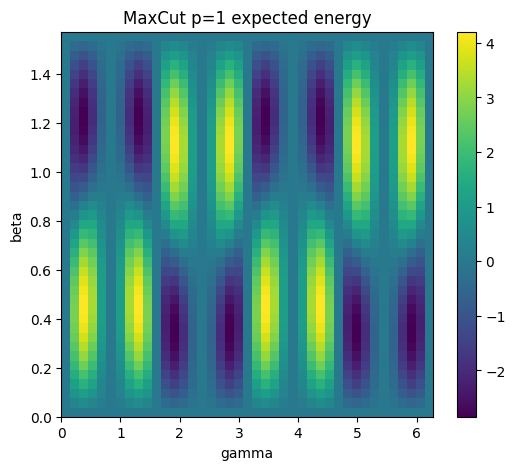

In [5]:
# Cell 3: grid
gamma_vals = np.linspace(0, 2*np.pi, 41)
beta_vals = np.linspace(0, np.pi/2, 41)
grid = np.zeros((len(beta_vals), len(gamma_vals)))
for ig, g in enumerate(gamma_vals):
    for ib, b in enumerate(beta_vals):
        qc = build_qaoa_circuit(h, J, [g], [b], n)
        sv = statevector_from_circuit(qc)
        E = expected_cost_from_statevector(sv, h, J)
        grid[ib, ig] = E
plot_heatmap(grid, gamma_vals, beta_vals, 'MaxCut p=1 expected energy', fname='results/figures/maxcut_p1_heatmap.png')


In [6]:
# Cell 4: find ground state by enumeration
E_min, ground_states = ground_state_energy_by_enumeration(h, J)
# pick a best gamma,beta from grid (min E)
ib_min, ig_min = np.unravel_index(np.argmin(grid), grid.shape)
g_best = gamma_vals[ig_min]
b_best = beta_vals[ib_min]
qc_best = build_qaoa_circuit(h, J, [g_best], [b_best], n)
counts = sample_bitstrings(qc_best, shots=2000)
E_sampled = energy_from_counts(counts, h, J)
p_success = success_probability_from_counts(counts, ground_states)
print('Ground energy (enumeration):', E_min)
print('Best grid gamma,beta:', g_best, b_best)
print('Sampled energy:', E_sampled)
print('Success prob (sampled):', p_success)


Ground energy (enumeration): -5.0
Best grid gamma,beta: 3.4557519189487724 1.2173671532660448
Sampled energy: -2.8280000000000003
Success prob (sampled): 0.41050000000000003


In [7]:
# Cell 5: knapsack test instance
values, weights, W = generate_random_knapsack(n=6, value_range=(5,20), weight_range=(1,5), seed=123)
print('values', values)
print('weights', weights, 'W=', W)
# convert to Ising h, J; lambda chosen
lam = 20.0
h_k, J_k, const_k = knapsack_to_ising(values, weights, W, lam=lam)
n_k = len(values)
# For simplicity, print a few
print('h_k sample (first 4):', {k:h_k[k] for k in list(h_k.keys())[:4]})
print('J_k sample (first 4):', list(J_k.items())[:4])


values [5, 15, 14, 5, 19, 8]
weights [2, 1, 2, 1, 2, 5] W= 6
h_k sample (first 4): {0: np.float64(132.5), 1: np.float64(67.5), 2: np.float64(137.0), 3: np.float64(62.5)}
J_k sample (first 4): [((0, 1), np.float64(10.0)), ((0, 2), np.float64(20.0)), ((0, 3), np.float64(10.0)), ((0, 4), np.float64(20.0))]


FileNotFoundError: [Errno 2] No such file or directory: 'results/figures/knapsack_p1_heatmap.png'

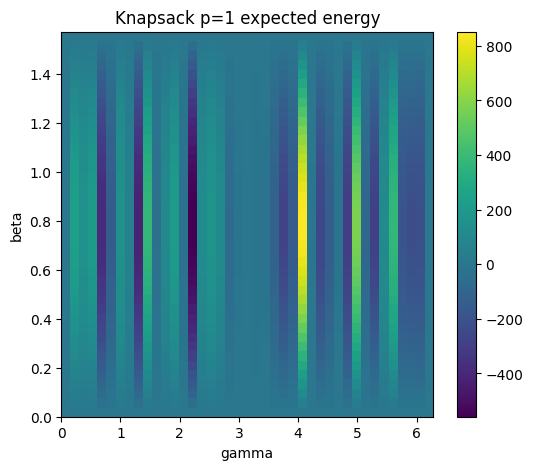

In [8]:
# Cell 6: grid for Knapsack (p=1)
gamma_vals = np.linspace(0, 2*np.pi, 41)
beta_vals = np.linspace(0, np.pi/2, 41)
grid_k = np.zeros((len(beta_vals), len(gamma_vals)))
for ig, g in enumerate(gamma_vals):
    for ib, b in enumerate(beta_vals):
        qc = build_qaoa_circuit(h_k, J_k, [g], [b], n_k)
        sv = statevector_from_circuit(qc)
        E = expected_cost_from_statevector(sv, h_k, J_k)
        grid_k[ib, ig] = E
plot_heatmap(grid_k, gamma_vals, beta_vals, 'Knapsack p=1 expected energy', fname='results/figures/knapsack_p1_heatmap.png')


In [9]:
# Cell 7: choose best gamma,beta (min energy)
ib_min, ig_min = np.unravel_index(np.argmin(grid_k), grid_k.shape)
g_best = gamma_vals[ig_min]
b_best = beta_vals[ib_min]
qc_best = build_qaoa_circuit(h_k, J_k, [g_best], [b_best], n_k)
counts = sample_bitstrings(qc_best, shots=4000)
# compute feasibility: need to map bitstrings to x vector and check weight constraint
def bitstr_to_x(bitstr):
    return [1 if ch == '1' else 0 for ch in bitstr[::-1]]  # reverse to match qubit ordering
total = sum(counts.values())
feasible = 0
best_val = None
best_feasible = None
for raw, c in counts.items():
    x = bitstr_to_x(raw)
    wsum = sum([x[i]*weights[i] for i in range(n_k)])
    if wsum <= W:
        feasible += c
        val = sum([x[i]*values[i] for i in range(n_k)])
        if (best_val is None) or val > best_val:
            best_val = val
            best_feasible = raw[::-1]
feas_rate = feasible/total
print('Feasibility rate:', feas_rate)
print('Best feasible sample value:', best_val, 'bitstring', best_feasible)


Feasibility rate: 0.00625
Best feasible sample value: 29 bitstring 100110


In [ ]:
# Cell 8: produce a small comparison table for p=1 vs p=2 quick sampling
# ... (similar approach: run p=2 optimization or grid, sample, compute metrics, store into pandas table, plot bar chart)
